In [1]:
import pykat
import numpy as np

import pykat.ifo.aligo as aligo
import pykat.ifo.aligo.plot
import matplotlib.pyplot as plt

import scipy
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

pykat.init_pykat_plotting(fmts=['svg'])

                                              ..-
    PyKat 1.1.240         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
%run LHO.py

base = make_LHO()
base.verbose = False
base.dumpify()

# We take a pickoff of the OMC refl and measure the beamscan along there
base.parse("s sOMC_REFL 2 nOMC_ICb nOMC_REFL")

# Data taken for matching the OPO beam to the OMC
# Furthest, Middle, and Closest refer to the second adjustable
# lens position after the OPO. Close means closest to the OPO
Furthest = np.array([[-0.2635,-0.2285,-0.2005,-0.1555,-0.1135],
                     [0.000621,0.000647,0.0006675,0.000714,0.000757],
                     [0.0004515,0.00046,0.000475,0.00049,0.00052]])

Closest  = np.array([[-0.2635,-0.2379,-0.1935,-0.1585,-0.1175],
                     [0.000334,0.000326,0.0003175,0.0003355,0.0003745],
                     [0.000358,0.000344,0.000327,0.000332,0.000354   ]])

Middle   = np.array([[-0.2635,-0.2379,-0.1935,-0.1615,-0.1205         ,1.2255,1.2255,1.2972,1.2972,1.3588,1.3588,1.419,1.419,1.474,1.474  ],
                     [0.000395,0.0003825,0.0004105,0.00043,0.0004585  ,0.001835,0.00182,0.00185,0.001885,0.001935,0.001825,0.002,0.002,0.00185,0.00205   ],
                     [0.000374,0.000373,0.0003735,0.0003885,0.0004055 ,0.001315,0.0013,0.00128,0.00136,0.00136,0.00139,0.001415,0.001345,0.00131,0.001365 ]])

OPO      = np.array([[2.5*25e-3, 28.5*25e-3, 39.75*25e-3, (16.5-2.125)*25e-3],
                     [2320e-6, 1830e-6, 1680e-6, 2030e-6],
                     [2301e-6, 1730e-6, 1590e-6, 2000e-6]])




def cav2node(cav_name, node, verbose =True, base=base):
    """
    This method traces a cavity's eigen mode to a
    given node in the model. 
    
    cav_name: cavity name
    node: node to trace beam to
    verbose: More or less info
    base: The kat object to do the tracing with
    """
    kat = base.deepcopy()

    for cav in kat.getAll(pykat.commands.cavity):
        if cav_name not in cav.name:
            cav.remove()

    kat.noxaxis = True
    kat.parse("pd p nAS")

    _, T = kat.run(getTraceData=True)
    qx, qy, _ = T[0][node]
    
    if verbose: print("%s -> %s" % (cav_name, node), qx.q, qy.q)
    return qx, qy


def single_bounce_SQZ(base, direction = 'x', verbose=True, to_node='nAS'):
    """
    This does a single bounce trace off of SRM HR surface from the OPO beam.
    This happens in two parts. Once trace from the OPO to the SRM HR
    a refl off of SRM HR, and then a trace from this reflected beam to
    the requested node.
    
    Returns the final q value going in to the OMC
    """
    SQZqx = base.sqz.nSQZ.qx 
    SQZqy = base.sqz.nSQZ.qy
    
    if direction == 'y':
        qin = SQZqy
    else:
        qin = SQZqx

    SQZ2SRM = base.beamTrace(qin, "nSQZ", "nSRMs1", direction=direction)
    
    #ITMX substrate
    n = base.SRMsub.n.value

    # Manually calculate the reflection off of SRM HR inside substrate
    q2 = pykat.optics.ABCD.apply(base.SRM.ABCD("nSRMs1", "nSRMs1", direction=direction),
                                 SQZ2SRM.q_out,
                                 n, n)

    if to_node != "nSRMs1":
        SRM2OMC = base.beamTrace(q2, "nSRMs1", to_node, direction=direction)

        if verbose:
            SQZ2SRM.print()
            SRM2OMC.print()

        return pykat.BeamParam(q=SRM2OMC.q_out)
    else:
        if verbose:
            SQZ2SRM.print()
        
        return pykat.BeamParam(q=SQZ2SRM.q_out)


Pykat parsing does not preserve inline comments. Moving inline
comments before command



AttributeError: 'int' object has no attribute 'data'

In [75]:
def beamsize_z(data, dz=1e-3):
    __z = np.array([])
    __w = np.array([])

    for comp, (from_node, to_node) in zip(data['components'], data['nodes']):
        if data[comp]['is_space']:
            L = data[comp]['L']
            q = data[from_node]['q']
            z = data[from_node]['z']

            _z = np.arange(0, L, dz)
            w  = q.beamsize(_z + q.z)/1e-3

            __z = np.hstack((__z, z + _z))
            __w = np.hstack((__w, w))

    return __z, __w

OPO = np.array([[2.5*25e-3, 28.5*25e-3, 39.75*25e-3, (16.5-2.125)*25e-3],
                [2320e-6, 1830e-6, 1680e-6, 2030e-6],
                [2301e-6, 1730e-6, 1590e-6, 2000e-6]])

def shift_lenses(kat, lens1_dz, lens2_pos, lens2_dz=0):
    lens2_range = 42e-3/2
    
    kat.lsqz_lens1.L       = 306e-3 - lens1_dz # edge of block to lens1
    kat.lsqz_lens1_lens2.L = 856e-3 - (2*lens2_pos-1) * lens2_range - lens2_dz - kat.lsqz_lens1.L.value # edge of block to lens2 (middle position) + lens translation - kat.lsqz_lens1.L
    OPO_block_to_ZM1       = 856e-3 + 73e-3 + 132e-3
    kat.lsqz_lens2_zm1.L   = OPO_block_to_ZM1 - kat.lsqz_lens1.L.value - kat.lsqz_lens1_lens2.L.value
    
def func_sqz_middle_fit(x, f1,f2, qin, direction, base):
    kat = base.deepcopy()

    kat.sqz_lens1.f = f1
    kat.sqz_lens2.f = f2

    lens2_pos, c, pos = [0.5, 'g', 'Middle']
    shift_lenses(kat, 0, lens2_pos)
    trace_SQZ_SRM = kat.beamTrace(qin, 'nSQZ', "nSRMs2", direction)
    z,w = beamsize_z(trace_SQZ_SRM.data, 10e-3)

    ZM1_pos = trace_SQZ_SRM.data['ZM1']['z']

    return interp1d(z, w)(x)

def func_sqz_middle_fitx(x,z,w0):
    return func_sqz_middle_fit(x,z,w0,base.sqz.nSQZ.qx,'x', kat)

def func_sqz_middle_fity(x,z,w0):
    return func_sqz_middle_fit(x,z,w0,base.sqz.nSQZ.qy,'y', kat)


We took a beam scan after ZM1 with lens2 in the middle position. Here we fit this beam shape by varying the q value used at the squeezer component. This is then the beam shape that is propagating towards the SRM. Assuming the lengths and lenses before lens2 are good, we can vary the lens2 position and predict the beam at the OMC later.

In [76]:
kat = base.deepcopy()


# From OPO geometry, thick M1, and distance of M1 HR from OPO block edge
base.sqz.nSQZ.qx.z  = -6.5e-3
base.sqz.nSQZ.qy.z  = -6.5e-3
base.sqz.nSQZ.qx.w0 = 214e-6
base.sqz.nSQZ.qy.w0 = 214e-6

trace_SQZ_SRM = kat.beamTrace(base.sqz.nSQZ.qx, 'nSQZ', "nSRMs2",'x')
ZM1_pos       = trace_SQZ_SRM.data['ZM1']['z']

xdata = ZM1_pos + OPO[0,:]
ydata = OPO[1,:]/2e-3
p0x = (kat.sqz_lens1.f.value, kat.sqz_lens2.f.value)
poptlensx, _ = curve_fit(func_sqz_middle_fitx, xdata, ydata, p0=p0x)

xdata = ZM1_pos + OPO[0,:]
ydata = OPO[2,:]/2e-3
p0y = (kat.sqz_lens1.f.value, kat.sqz_lens2.f.value)
poptlensy, _ = curve_fit(func_sqz_middle_fity, xdata, ydata, p0=p0y)

display("x fit [z,w0]", poptlensx)
display("y fit [z,w0]", poptlensy)

'x fit [z,w0]'

array([ 0.11383169,  0.34906024])

'y fit [z,w0]'

array([ 0.11356594,  0.34479291])

(0, 3)

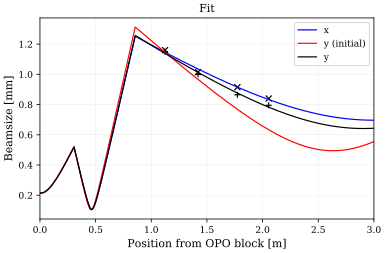

In [77]:
z = np.linspace(0, 3, 1000)

plt.plot(z, func_sqz_middle_fitx (z, *poptlensx), label='x')
plt.scatter(ZM1_pos + OPO[0,:], OPO[1,:]/2e-3, color='k', marker='x')

plt.plot(z, func_sqz_middle_fity(z, *p0y), label='y (initial)')
plt.plot(z, func_sqz_middle_fity(z, *poptlensy), label='y')
plt.scatter(ZM1_pos + OPO[0,:], OPO[2,:]/2e-3, color='k', marker='+')

plt.xlabel("Position from OPO block [m]")
plt.ylabel("Beamsize [mm]")
plt.legend()
plt.title("Fit")
plt.xlim(0, 3)

In [80]:
# set average of lens for now
base.sqz_lens1.f = (poptlensx[0] + poptlensy[0])/2
base.sqz_lens2.f = (poptlensx[1] + poptlensy[1])/2

In [81]:
def run(kat):
    """
    This function runs the provided kat object to trace the beam form the
    OPO to the OMC. It plots the data taken against the model generated.
    The parameters of the model can be changed by changing the input kat.
    The popt x/y are the optimised qx and qy from the fitting before of the
    beam coming out of the OPO after ZM1.
    """
    fig = plt.figure(figsize=(4*2, 4))
    ax = plt.subplot(111)

    fig2 = plt.figure(figsize=(4*2, 4))
    ax2 = plt.subplot(111)

    # Get cavity OMC q at SRM...
    OMCqx, OMCqy = cav2node('OMC', 'nSRM2', kat)
    OMCqx.reverse()
    OMCqy.reverse()
    
    # Then trace it back to get the beam shape
    trace_OMCx = kat.beamTrace(OMCqx, 'nSRM2', "nOMC_REFL",'x')
    trace_OMCx.plot_beamsize(ax=ax2, color='k', ls='--', label="OMC")
    trace_OMCy = kat.beamTrace(OMCqy, 'nSRM2', "nOMC_REFL",'y')
    trace_OMCy.plot_beamsize(ax=ax2, color='k', ls=':', label="OMC")

    # Loop over the three lens2 options and do the tracing
    for lens2_pos,c,pos in zip([0.05, 0.5, 0.95], ['r','g','b'], ['Far', 'Middle', 'Close']):
        shift_lenses(kat, 0, lens2_pos)

        trace_SQZ_SRMx = kat.beamTrace(kat.sqz.nSQZ.qx, 'nSQZ', "nSRMs2",'x')
        trace_SQZ_SRMx.plot_beamsize(ax=ax, color=c, label=pos + '(x)')

        qx = single_bounce_SQZ(kat, 'x', False, 'nSRM2')

        trace_SRM_OMCx = kat.beamTrace(qx, 'nSRM2', "nOMC_REFL",'x')
        trace_SRM_OMCx.plot_beamsize(ax=ax2, color=c, label=pos + '(x)')

        trace_SQZ_SRMy = kat.beamTrace(kat.sqz.nSQZ.qy, 'nSQZ', "nSRMs2",'y')
        trace_SQZ_SRMy.plot_beamsize(ax=ax, color=c, label=pos + '(y)', ls='--')

        qy = single_bounce_SQZ(kat, 'y', False, 'nSRMs2')

        trace_SRM_OMCy = kat.beamTrace(qy, 'nSRMs2', "nOMC_REFL",'y')
        trace_SRM_OMCy.plot_beamsize(ax=ax2, color=c, label=pos + '(y)', ls='--')

        print(pos, "x", pykat.BeamParam.overlap(trace_SRM_OMCx.q_out, trace_OMCx.q_out))
        print(pos, "y", pykat.BeamParam.overlap(trace_SRM_OMCy.q_out, trace_OMCy.q_out))

    OMC_waist_pos = trace_OMCx.data['OM3']['z'] + 0.117 + 0.2 + 0.141
    ZM1_pos = trace_SQZ_SRM.data['ZM1']['z']

    # Factor of two because measurement in diameter
    ax.scatter(ZM1_pos + OPO[0,:], OPO[1,:]/2e-3, color='k', marker='x')
    ax.scatter(ZM1_pos + OPO[0,:], OPO[2,:]/2e-3, color='k', marker='+')

    ax2.scatter(OMC_waist_pos + Furthest[0,:], Furthest[1,:]/1e-3, color='r', marker='x', label='meas x')
    ax2.scatter(OMC_waist_pos + Middle[0,:],   Middle[1,:]/1e-3, color='g', marker='x',   label='meas x')
    ax2.scatter(OMC_waist_pos + Closest[0,:],  Closest[1,:]/1e-3, color='b', marker='x',  label='meas x')

    ax2.scatter(OMC_waist_pos + Furthest[0,:], Furthest[2,:]/1e-3, color='r', marker='+', label='meas y')
    ax2.scatter(OMC_waist_pos + Middle[0,:],   Middle[2,:]/1e-3, color='g', marker='+',   label='meas y')
    ax2.scatter(OMC_waist_pos + Closest[0,:],  Closest[2,:]/1e-3, color='b', marker='+',  label='meas y')

    ax.set_xlabel("OPO -> SRM")
    ax.legend()
    ax.set_ylim(0,3)

    ax2.set_xlabel("SRM -> OMC REFL")
    ax2.legend()
    ax2.set_ylim(0,3)

    ax2.set_xlim(5.3, None)
    ax2.set_ylim(0, None)

OMC -> nSRM2 (3.35633359166686+1.01508402834356j) (3.34567436712542+1.02266509560728j)
Far x 0.7720189127972361
Far y 0.7733340619665323
Middle x 0.8175566724453955
Middle y 0.8206731148533224
Close x 0.8178886170164865
Close y 0.8222246378955698


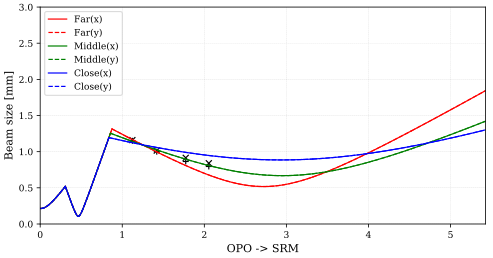

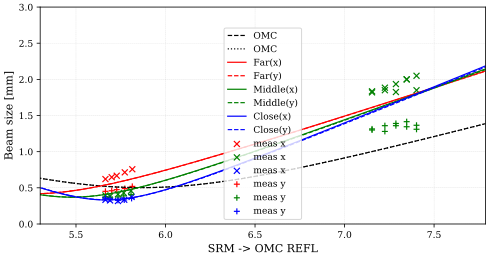

In [82]:
kat = base.deepcopy()
kat.lzm1_zm2.L = 2260e-3
kat.sOM1_OM2.L = 1.39
run(kat)

This fit looks reasonable considering we still don't have a good explanation for the amount of astigmatism. However the waist position and size of the closest and middle values are looking comparable to https://alog.ligo-wa.caltech.edu/aLOG/index.php?callRep=41504. Furthest is still a bit odd. The astigmatism is large, perhaps the lens2 is not centered or shifted...

Assuming this represents the close and middle results well though we can now shift the lens even closer and check the mismatching to the OMC.

In [83]:
def run_change_lens2(kat):
    fig2 = plt.figure(figsize=(4*2, 4))
    ax2 = plt.subplot(111)

    OMCqx, OMCqy = cav2node('OMC', 'nSRM2', kat)
    OMCqx.reverse()
    OMCqy.reverse()

    trace_OMCx = kat.beamTrace(OMCqx, 'nSRM2', "nOMC_REFL",'x')
    trace_OMCx.plot_beamsize(ax=ax2, color='k', ls='--', label="OMC")

    trace_OMCy = kat.beamTrace(OMCqy, 'nSRM2', "nOMC_REFL",'y')
    trace_OMCy.plot_beamsize(ax=ax2, color='k', ls=':', label="OMC")

    # Here shift the lens 2 and 4 cm closer compared to the cloest position, and see what happens...
    for dl,c,pos in zip([0e-2, 2e-2, 4e-2], ['r','g','b'], ['0cm', '2cm', '4cm']):
        pos = "%.2f cm" % (dl*100)
        lens2_pos = 0.95 # factor of 0.95 for total 42mm range, is kind of right for the closest measurement we did before
        
        shift_lenses(kat, 0, lens2_pos, dl)
        
        trace_SQZ_SRMx = kat.beamTrace(kat.sqz.nSQZ.qx, 'nSQZ', "nSRMs2",'x')
        
        qx = single_bounce_SQZ(kat, 'x', False, 'nSRM2')

        trace_SRM_OMCx = kat.beamTrace(qx, 'nSRM2', "nOMC_REFL",'x')
        trace_SRM_OMCx.plot_beamsize(ax=ax2, color=c, label=pos + '(x)')

        trace_SQZ_SRMy = kat.beamTrace(kat.sqz.nSQZ.qy, 'nSQZ', "nSRMs2",'y')
        
        qy = single_bounce_SQZ(kat, 'y', False, 'nSRMs2')

        trace_SRM_OMCy = kat.beamTrace(qy, 'nSRMs2', "nOMC_REFL",'y')
        trace_SRM_OMCy.plot_beamsize(ax=ax2, color=c, label=pos + '(y)', ls='--')

        print(pos, "x mismatch", pykat.BeamParam.overlap(trace_SRM_OMCx.q_out, trace_OMCx.q_out))
        print(pos, "y mismatch", pykat.BeamParam.overlap(trace_SRM_OMCy.q_out, trace_OMCy.q_out))

    ax2.set_xlabel("SRM AR -> OMC REFL")
    ax2.legend()
    ax2.set_ylim(0,3)

    ax2.set_xlim(5.3, 6.5)
    ax2.set_ylim(0, 1)

OMC -> nSRM2 (3.35633359166686+1.01508402834356j) (3.34567436712542+1.02266509560728j)
0.00 cm x mismatch 0.8178886170164865
0.00 cm y mismatch 0.8222246378955698
2.00 cm x mismatch 0.7677497422361395
2.00 cm y mismatch 0.7722967231299851
4.00 cm x mismatch 0.6813650600776813
4.00 cm y mismatch 0.6851910708966128


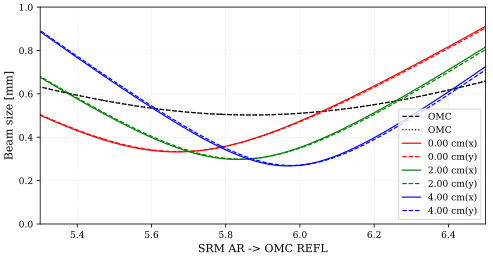

In [84]:
kat = base.deepcopy()
kat.lzm1_zm2.L = 2260e-3
kat.sOM1_OM2.L = 1.39
run_change_lens2(kat)

So we see that the mode matching gets worse as we move lens2 closer...

The waist position gets better but it also gets smaller which hurts us.

In [112]:

    
def run_change_lens1(kat):
    fig2 = plt.figure(figsize=(4*2, 4))
    ax2 = plt.subplot(111)

    OMCqx, OMCqy = cav2node('OMC', 'nSRM2', kat)
    OMCqx.reverse()
    OMCqy.reverse()

    trace_OMCx = kat.beamTrace(OMCqx, 'nSRM2', "nOMC_REFL",'x')
    trace_OMCx.plot_beamsize(ax=ax2, color='k', ls='--', label="OMC")

    trace_OMCy = kat.beamTrace(OMCqy, 'nSRM2', "nOMC_REFL",'y')
    trace_OMCy.plot_beamsize(ax=ax2, color='k', ls=':', label="OMC")

    # Here shift the lens 2 and 4 cm closer compared to the cloest position, and see what happens...
    for dl,c,pos in zip([0e-2, 2e-2, 8e-2], ['r','g','b'], ['0cm', '2cm', '4cm']):
        pos = "%.2f cm" % (dl*100)
        
        shift_lenses(kat, dl, 0.95, 8e-2)
        
        trace_SQZ_SRMx = kat.beamTrace(kat.sqz.nSQZ.qx, 'nSQZ', "nSRMs2",'x')
        
        qx = single_bounce_SQZ(kat, 'x', False, 'nSRM2')

        trace_SRM_OMCx = kat.beamTrace(qx, 'nSRM2', "nOMC_REFL",'x')
        trace_SRM_OMCx.plot_beamsize(ax=ax2, color=c, label=pos + '(x)')

        trace_SQZ_SRMy = kat.beamTrace(kat.sqz.nSQZ.qy, 'nSQZ', "nSRMs2",'y')
        
        qy = single_bounce_SQZ(kat, 'y', False, 'nSRMs2')

        trace_SRM_OMCy = kat.beamTrace(qy, 'nSRMs2', "nOMC_REFL",'y')
        trace_SRM_OMCy.plot_beamsize(ax=ax2, color=c, label=pos + '(y)', ls='--')

        print(kat.lsqz_lens1.L.value, kat.lsqz_lens1_lens2.L.value, kat.lsqz_lens2_zm1.L.value)
        print(pos, "x mismatch", pykat.BeamParam.overlap(trace_SRM_OMCx.q_out, trace_OMCx.q_out))
        print(pos, "y mismatch", pykat.BeamParam.overlap(trace_SRM_OMCy.q_out, trace_OMCy.q_out))

    ax2.set_xlabel("SRM AR -> OMC REFL")
    ax2.legend()
    ax2.set_ylim(0,3)

    ax2.set_xlim(5.3, 6.5)
    ax2.set_ylim(0, 1)

OMC -> nSRM2 (3.35633359166686+1.01508402834356j) (3.34567436712542+1.02266509560728j)
0.306 0.4511 0.3038999999999999
0.00 cm x mismatch 0.4841459938407244
0.00 cm y mismatch 0.48584535645479904
0.286 0.4711 0.3038999999999999
2.00 cm x mismatch 0.6186232683286376
2.00 cm y mismatch 0.6212092062597334
0.22599999999999998 0.5311 0.30389999999999995
8.00 cm x mismatch 0.971524853761278
8.00 cm y mismatch 0.9735649426666012


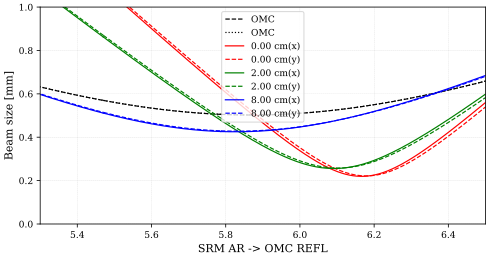

In [113]:
kat = base.deepcopy()
kat.lzm1_zm2.L = 2260e-3
kat.sOM1_OM2.L = 1.39
run_change_lens1(kat)